In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers, Input, Model, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
#pip install keras-tuner --upgrade
import keras_tuner as kt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn import svm
from sklearn.metrics import *
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


1. Data import

In [4]:
data = pd.read_csv('data/spam.csv')

In [5]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
data = data.iloc[:,:2]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
data['v1'].value_counts()/data.shape[0]

ham     0.865937
spam    0.134063
Name: v1, dtype: float64

In [9]:
data['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

How we can see our data set is unbalanced, 86.5% to 13.5% percent, in favor of not spam.

2. Data cleaning and preprocessing

In [20]:
# let transform our labels to binary values
Y = LabelEncoder().fit_transform(data['v1']).reshape(-1,1)
Y.shape

(5572, 1)

In [10]:
X = data['v2']
X.shape

(5572,)

In [11]:
# Let check how many words we have in our dataset

# tokenize the document
words = []

for i in range(0, X.shape[0]):
    result = text_to_word_sequence(X[i])
    words.extend(result)
    
len(set(words))

8916

In [12]:
# Let see top 10 words, whether there are some useless words or single characters
pd.DataFrame(words).value_counts().head(10)

i      2351
to     2242
you    2150
a      1433
the    1328
u      1172
and     979
in      898
is      889
me      802
dtype: int64

How we can see, many of our popular words are stopwords, let remove them.

In [13]:
# Our stopwords which we'll remove are presented below
#nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df = pd.DataFrame(X)
stop_words = set(stopwords.words('english'))


df['clean'] = df['v2'].apply(lambda x: ' '.join([word for word in x.split() if not word.lower() in (stop_words)]))
print(df)

                                                     v2  \
0     Go until jurong point, crazy.. Available only ...   
1                         Ok lar... Joking wif u oni...   
2     Free entry in 2 a wkly comp to win FA Cup fina...   
3     U dun say so early hor... U c already then say...   
4     Nah I don't think he goes to usf, he lives aro...   
...                                                 ...   
5567  This is the 2nd time we have tried 2 contact u...   
5568              Will �_ b going to esplanade fr home?   
5569  Pity, * was in mood for that. So...any other s...   
5570  The guy did some bitching but I acted like i'd...   
5571                         Rofl. Its true to its name   

                                                  clean  
0     Go jurong point, crazy.. Available bugis n gre...  
1                         Ok lar... Joking wif u oni...  
2     Free entry 2 wkly comp win FA Cup final tkts 2...  
3             U dun say early hor... U c already say...  
4

In [15]:
# Let check again if there are still any useless words not included in stopwords

# tokenize the document
words = []
df = df['clean']

for i in range(0, df.shape[0]):
    result = text_to_word_sequence(df[i])
    words.extend(result)
    
len(set(words))

    
pd.DataFrame(words).value_counts().head(20)
#there are still some stopwords

u       1172
call     591
2        515
i'm      394
get      391
ur       385
gt       318
lt       316
4        316
ok       287
free     284
go       280
know     261
now      255
good     245
like     245
got      239
you      233
come     229
time     220
dtype: int64

In [16]:
# let remove another stopwords, not defined before

more_stopwords = set(['u','4','2',"i'm","i'll",'r','ur','n'])
updated_step_words = stop_words | more_stopwords

df1 = pd.DataFrame(df)

df1['clean_1'] = df1['clean'].apply(lambda x: ' '.join([word for word in x.split() if not word.lower() in (updated_step_words)]))
print(df1)

                                                  clean  \
0     Go jurong point, crazy.. Available bugis n gre...   
1                         Ok lar... Joking wif u oni...   
2     Free entry 2 wkly comp win FA Cup final tkts 2...   
3             U dun say early hor... U c already say...   
4               Nah think goes usf, lives around though   
...                                                 ...   
5567  2nd time tried 2 contact u. U �750 Pound prize...   
5568                      �_ b going esplanade fr home?   
5569           Pity, * mood that. So...any suggestions?   
5570  guy bitching acted like i'd interested buying ...   
5571                                    Rofl. true name   

                                                clean_1  
0     Go jurong point, crazy.. Available bugis great...  
1                           Ok lar... Joking wif oni...  
2     Free entry wkly comp win FA Cup final tkts 21s...  
3                 dun say early hor... c already say...  
4

In [18]:
#let steem words in our dataset
ps = PorterStemmer()

def porter(text):
    text = nltk.word_tokenize(text) # split sentence to words
    text_set = []                   # empty list
    for i in text:                  # for each word do...
        text_set.append(ps.stem(i)) # steem and append to list

    return " ".join(text_set)       # join every word in list back to sentence

df1['text_steemed'] =df1['clean_1'].apply(porter)
df1

,clean,clean_1,text_steemed
0,"Go jurong point, crazy.. Available bugis n gre...","Go jurong point, crazy.. Available bugis great...","go jurong point , crazi .. avail bugi great wo..."
1,Ok lar... Joking wif u oni...,Ok lar... Joking wif oni...,ok lar ... joke wif oni ...
2,Free entry 2 wkly comp win FA Cup final tkts 2...,Free entry wkly comp win FA Cup final tkts 21s...,free entri wkli comp win fa cup final tkt 21st...
3,U dun say early hor... U c already say...,dun say early hor... c already say...,dun say earli hor ... c alreadi say ...
4,"Nah think goes usf, lives around though","Nah think goes usf, lives around though","nah think goe usf , live around though"
...,...,...,...
5567,2nd time tried 2 contact u. U �750 Pound prize...,2nd time tried contact u. �750 Pound prize. cl...,2nd time tri contact u . �750 pound prize . cl...
5568,�_ b going esplanade fr home?,�_ b going esplanade fr home?,�_ b go esplanad fr home ?
5569,"Pity, * mood that. So...any suggestions?","Pity, * mood that. So...any suggestions?","piti , * mood that . so ... ani suggest ?"
5570,guy bitching acted like i'd interested buying ...,guy bitching acted like i'd interested buying ...,guy bitch act like i 'd interest buy someth el...


In [21]:
# Let split our dataset on train and test
X_train, X_test,Y_train, Y_test = train_test_split(df1['text_steemed'],Y, test_size= 0.2, random_state=1)

3. Text tokenize

In [ ]:
x_list musi byc lista slow z kazdego wiersza

In [22]:
# let check the longest sms (number of words) in our dataset
num_words = df1['text_steemed'].apply(lambda x: len(nltk.word_tokenize(x)))
num_words.max()

205

number of words represents 99% percentile is  41.29


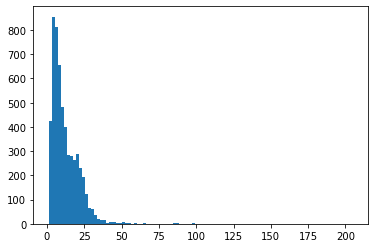

In [25]:
#How looks the range of words per messege
_= plt.hist(num_words, bins = 100)
print('number of words represents 99% percentile is ', round(np.quantile(num_words,0.99),2))

In [26]:
#let create tokenizer to apply values for each word
max_words = 800
max_len = 42

tok = Tokenizer(max_words,lower= True)
tok.fit_on_texts(X_train) #token trainging on X_train

sequences = tok.texts_to_sequences(X_train) #conversion from text to vectors
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len) #matrix with padding has been created

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [27]:
#let check records where after tokenizing we have only zeros
test_0 = pd.DataFrame({"X" : test_sequences_matrix.argmax(axis=1)})
test_0_filtred = test_0[test_0["X"]<1]

test_to_remove = test_0_filtred.index

train_0 = pd.DataFrame({"X" : sequences_matrix.argmax(axis=1)})
train_0_filtred = train_0[train_0["X"]<1]

train_to_remove = train_0_filtred.index

In [28]:
# let remove those zeros tokens from our dataset 

#X_train 
sequences_matrix = np.delete(sequences_matrix, train_to_remove,axis = 0 )

#X_test
test_sequences_matrix =  np.delete(test_sequences_matrix, test_to_remove,axis = 0 )

#Y_train
Y_train = np.delete(Y_train, train_to_remove, axis = 0)

#Y_test
Y_test = np.delete(Y_test, test_to_remove, axis = 0)

4. Models implementation

In [41]:
# to make reproduced results.
np.random.seed(400)

a) SVM

In [30]:
#simple model as benchmark

model1_svm = make_pipeline(MinMaxScaler(),svm.SVC())
model1_svm.fit(sequences_matrix, Y_train.flatten())

y_pred1_svm = model1_svm.predict(test_sequences_matrix)

# evaluation
print(classification_report(Y_test.flatten(),y_pred1_svm))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       960
           1       0.82      0.45      0.58       139

    accuracy                           0.92      1099
   macro avg       0.87      0.72      0.77      1099
weighted avg       0.91      0.92      0.91      1099



As we can see, model predict not-spam class very well, but reach only 58% f1_score for spam class.  

We are going to improve this model a little bit, by changing default parameters.

In [32]:
# another simple model

model2_svm = make_pipeline(MinMaxScaler(),svm.SVC(kernel = 'poly'))
model2_svm.fit(sequences_matrix, Y_train.flatten())

y_pred2_svm = model2_svm.predict(test_sequences_matrix)


# evaluation
print(classification_report(Y_test.flatten(),y_pred2_svm))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       960
           1       0.72      0.42      0.53       139

    accuracy                           0.91      1099
   macro avg       0.82      0.70      0.74      1099
weighted avg       0.90      0.91      0.90      1099



In [33]:
# another simple model

model3_svm = make_pipeline(MinMaxScaler(),svm.SVC(kernel = 'linear'))
model3_svm.fit(sequences_matrix, Y_train.flatten())

y_pred3_svm = model3_svm.predict(test_sequences_matrix)


# evaluation
print(classification_report(Y_test.flatten(),y_pred3_svm))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       960
           1       0.57      0.25      0.35       139

    accuracy                           0.88      1099
   macro avg       0.74      0.61      0.64      1099
weighted avg       0.86      0.88      0.86      1099



Three basic models with default parameters, only with different kernel don't reach sufficient results.

b) KNN

In [42]:
# simple model as benchmark

model1_knn = make_pipeline(MinMaxScaler(),KNeighborsClassifier())
model1_knn.fit(sequences_matrix, Y_train.flatten())

y_pred1_knn = model1_knn.predict(test_sequences_matrix)

# evaluation
print(classification_report(Y_test.flatten(),y_pred1_knn))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       960
           1       0.67      0.47      0.56       139

    accuracy                           0.90      1099
   macro avg       0.80      0.72      0.75      1099
weighted avg       0.89      0.90      0.90      1099



In [43]:
# simple model as benchmark

model2_knn = make_pipeline(MinMaxScaler(),KNeighborsClassifier(weights = 'distance'))
model2_knn.fit(sequences_matrix, Y_train.flatten())

y_pred2_knn = model2_knn.predict(test_sequences_matrix)

# evaluation
print(classification_report(Y_test.flatten(),y_pred2_knn))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       960
           1       0.78      0.63      0.70       139

    accuracy                           0.93      1099
   macro avg       0.86      0.80      0.83      1099
weighted avg       0.93      0.93      0.93      1099



In [44]:
# simple model as benchmark

model3_knn = make_pipeline(StandardScaler(),KNeighborsClassifier(weights = 'distance'))
model3_knn.fit(sequences_matrix, Y_train.flatten())

y_pred3_knn = model3_knn.predict(test_sequences_matrix)

# evaluation
print(classification_report(Y_test.flatten(),y_pred3_knn))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       960
           1       0.74      0.63      0.68       139

    accuracy                           0.93      1099
   macro avg       0.84      0.80      0.82      1099
weighted avg       0.92      0.93      0.92      1099



How we can see first, basic KNN model didn't improve our previous results, but with only one change in weight parameters, we beat out previous best result. 
Finally with StandardScaler instead of MinMaxScaller our results was a little bit better.  
Let try with more another option.

c) RandomForrest

In [45]:
#simple model as benchmark
model1_rf = RandomForestClassifier(random_state=1)
model1_rf.fit(sequences_matrix, Y_train.flatten())

y_pred1_rf = model1_rf.predict(test_sequences_matrix)

# evaluation
print(classification_report(Y_test.flatten(),y_pred1_rf))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       960
           1       0.87      0.65      0.75       139

    accuracy                           0.94      1099
   macro avg       0.91      0.82      0.86      1099
weighted avg       0.94      0.94      0.94      1099



After first try, in default model we reached the highest f1 score on this dataset.
Let check more sofisticated model form keras library.

d) simple neural network

In [46]:
# first we have to prepare Y_train and Y_test to correct shape
Y_train_encoded = OneHotEncoder(sparse= False).fit_transform(Y_train)
Y_test_encoded = OneHotEncoder(sparse= False).fit_transform(Y_test)

In [47]:
#set result repeatable

set_seed(2)

In [49]:
# first DL model
input_layer = Input(shape = sequences_matrix.shape[1])

x1 = layers.Dense(128, activation='relu')(input_layer)
x1 = layers.Dense(64, activation='relu')(x1)

out = layers.Dense(2)(x1)

out = layers.Softmax()(out)

model_dl1 = Model(inputs = input_layer, outputs = out)
model_dl1.compile(optimizer= 'Adam', loss = 'binary_crossentropy', metrics = 'AUC')

model_dl1.fit(sequences_matrix, Y_train_encoded, epochs = 20, validation_split=0.1, callbacks=EarlyStopping(patience=3, monitor='val_loss', min_delta = 0.02))

y_pred_dl1 = model_dl1.predict(test_sequences_matrix).argmax(axis = 1) 

print(classification_report(Y_test.flatten(),y_pred_dl1))

Epoch 1/20
124/124 [==============================] - 2s 5ms/step - loss: 2.3399 - auc: 0.8443 - val_loss: 2.1315 - val_auc: 0.8604
Epoch 2/20
124/124 [==============================] - 0s 2ms/step - loss: 2.1208 - auc: 0.8608 - val_loss: 2.1314 - val_auc: 0.8604
Epoch 3/20
124/124 [==============================] - 0s 2ms/step - loss: 2.1207 - auc: 0.8614 - val_loss: 2.1313 - val_auc: 0.8607
Epoch 4/20
124/124 [==============================] - 0s 3ms/step - loss: 2.1207 - auc: 0.8615 - val_loss: 2.1313 - val_auc: 0.8607
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       960
           1       0.00      0.00      0.00       139

    accuracy                           0.87      1099
   macro avg       0.44      0.50      0.47      1099
weighted avg       0.76      0.87      0.81      1099



C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


How we can see, simple DL model hasn't improve our result.  
Model with only dense layer can't predict spam class,
let improve it, by adding recurential layers.

e) rnn networks

In [50]:
# our model definition
def model_rnn(X_train,Y_train, units_rnn, embedd = 64, opt = 'adam', metrics = 'AUC', drop = 0, batch = 64, epochs = 30, verbose = True, display = 2):
    
    '''
    X_train = training data without labels, in matrix format, prepared earlier as a sequences_matrix,
    Y_train = labels for training data as an array(None, 2),
    units_rnn = list of units per layer, same units per layer are recommended
    embedd = dimension of embedding, default 64
    opt = optimizer as a string,  default = 'adam'
    drop = dropout size, default = 0
    metric = metric to evaluate model results, default = 'auc'
    batch = batch size, default 64, NOTE than batch size should be divided by 8
    epochs = number of epochs, iteration of model, default = 30
    verbose = whether print model summary or not, default = true (print)
    display = whether print during fit progres bar (1), oneline summary per epoch (2) or nothing (0), default 2
    
    max_words = number of words used in model, parameter defined in preprocessing stage,
    max_len = maximal lenght of one record, number of words in one record, parameter defined in preprocessing stage,
    
    '''
    
    # model instance
    model = models.Sequential()
    
    # input layer
    model.add(
        layers.InputLayer(
                    name = 'intro', 
                    input_shape = max_len
        )
    )
    
    # text embedding
    model.add(
        layers.Embedding(
            input_dim = max_words,
            output_dim=embedd
        )
    )
    
    # model with LSTM layers, and dense as an output
    for i, j in enumerate(units_rnn):
        if i == len(units_rnn)-1 and i == 0:
            model.add(
                layers.LSTM(
                    units = j, 
                    name = 'rnn' + str(i)
                )
            )
        
        elif i == len(units_rnn)-1:
             model.add(
                layers.LSTM(
                    units = j, 
                    name = 'rnn' + str(i)
                )
            )
        
        
        else:
            model.add(
                layers.LSTM(
                    units = j, 
                    return_sequences = True,
                    name = 'rnn' + str(i)
                )
            )
            
    model.add(layers.Dropout(rate = drop))
            
    model.add(
        layers.Dense(
            units=2,
            name = 'out'
            )
        )  
    
    
    model.add(layers.Softmax())
        
    if verbose == True:
        model.summary()
    
    
    # model compile
    model.compile(
            loss = 'binary_crossentropy',
            optimizer = opt,
            metrics = metrics
    )
    
    # model fit
    model.fit(
        x = X_train,
        y = Y_train,
        batch_size = batch,
        epochs = epochs,
        validation_split = 0.2,
        verbose = display,
        callbacks = [EarlyStopping(
                            monitor ='val_loss',
                            patience = 5,
                            min_delta = 0.01
                            )]
    )
    
    
    return model

In [703]:
model_rnn1 = model_rnn(sequences_matrix,Y_train_encoded,[64], display = 2)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 70, 64)            51200     
_________________________________________________________________
rnn0 (LSTM)                  (None, 64)                33024     
_________________________________________________________________
out (Dense)                  (None, 2)                 130       
_________________________________________________________________
softmax_6 (Softmax)          (None, 2)                 0         
Total params: 84,354
Trainable params: 84,354
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
55/55 [==============================] - 36s 324ms/step - loss: 0.3352 - auc: 0.9381 - val_loss: 0.1541 - val_auc: 0.9860
Epoch 2/30
55/55 [==============================] - 28s 508ms/step - loss: 0.0683 - auc: 0.9963 - val_loss: 0.0840

In [704]:
# model evaluation results
res = model_rnn1.evaluate(test_sequences_matrix,Y_test_encoded, verbose=0)
print('Test set\n  Loss: {:0.2f}\n  AUC: {:0.2f}'.format(res[0],res[1]))

Test set
  Loss: 0.05
  AUC: 1.00


In [705]:
# classification report
y_pred = model_rnn1.predict(test_sequences_matrix).argmax(axis = 1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       948
           1       0.98      0.94      0.96       139

    accuracy                           0.99      1087
   macro avg       0.98      0.97      0.97      1087
weighted avg       0.99      0.99      0.99      1087



How we can see our model, have almost perfect match, it makes only some mistakes, and not spam messeges classify as a spam.
Let's go to optimize recall_score for 'spam' class.

In [715]:
#precision score for class 'spam'
precision_score(Y_test, y_pred,pos_label=1)

0.9774436090225563

In [51]:
parameters = { "units_rnn" : [[64,64],[128],[128,128],[32],[32,32]]}    

results = pd.DataFrame({"units_rnn" : [], "recall" : []})

lenght = len(parameters["units_rnn"])

for i in range(lenght):
    param = parameters.get("units_rnn")[i]
    model = model_rnn(sequences_matrix,Y_train_encoded,param, verbose = False)
    y_pred = model.predict(test_sequences_matrix).argmax(axis = 1)
    print('model' + str(i+1), "\n")
    
    recall = recall_score(Y_test, y_pred,pos_label=1)
    results = results.append({"units_rnn": param,"recall" : recall}, ignore_index = True)
    
print(results)

Epoch 1/30
55/55 - 12s - loss: 0.3261 - auc: 0.9371 - val_loss: 0.0965 - val_auc: 0.9934
Epoch 2/30
55/55 - 5s - loss: 0.0771 - auc: 0.9944 - val_loss: 0.0433 - val_auc: 0.9993
Epoch 3/30
55/55 - 5s - loss: 0.0409 - auc: 0.9987 - val_loss: 0.0352 - val_auc: 0.9994
Epoch 4/30
55/55 - 6s - loss: 0.0257 - auc: 0.9995 - val_loss: 0.0398 - val_auc: 0.9990
Epoch 5/30
55/55 - 6s - loss: 0.0169 - auc: 0.9995 - val_loss: 0.0397 - val_auc: 0.9993
Epoch 6/30
55/55 - 5s - loss: 0.0105 - auc: 0.9996 - val_loss: 0.0468 - val_auc: 0.9976
Epoch 7/30
55/55 - 6s - loss: 0.0102 - auc: 0.9996 - val_loss: 0.0540 - val_auc: 0.9982
model1 

Epoch 1/30
55/55 - 9s - loss: 0.3258 - auc: 0.9402 - val_loss: 0.0951 - val_auc: 0.9973
Epoch 2/30
55/55 - 5s - loss: 0.0700 - auc: 0.9954 - val_loss: 0.0366 - val_auc: 0.9996
Epoch 3/30
55/55 - 5s - loss: 0.0388 - auc: 0.9990 - val_loss: 0.0279 - val_auc: 0.9996
Epoch 4/30
55/55 - 5s - loss: 0.0260 - auc: 0.9993 - val_loss: 0.0274 - val_auc: 0.9997
Epoch 5/30
55/55 - 5s 

How we can see the best results we achieved with less amount of units, the best with 32 units and one layer

In [52]:
# let try with some droupout
model_rnn2 = model_rnn(sequences_matrix,Y_train_encoded,[32], drop = 0.2)
y_pred2 = model_rnn2.predict(test_sequences_matrix).argmax(axis = 1)
precision_score(Y_test, y_pred2,pos_label=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 42, 64)            51200     
_________________________________________________________________
rnn0 (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
out (Dense)                  (None, 2)                 66        
_________________________________________________________________
softmax_7 (Softmax)          (None, 2)                 0         
Total params: 63,682
Trainable params: 63,682
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
55/55 - 7s - loss: 0.3797 - auc: 0.9242 - val_loss: 0.1543 - val_auc: 0.9887
Epoch 2/30
55/55 - 2s - loss

0.9774436090225563

In [53]:
print(classification_report(Y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       960
           1       0.98      0.94      0.96       139

    accuracy                           0.99      1099
   macro avg       0.98      0.97      0.97      1099
weighted avg       0.99      0.99      0.99      1099



How we can see there is no impact on results with dropout layer


f) Keras tuner

In [55]:
# let try improve our model with keras tuner
# first create model instance

def build_model(hp):
        model = models.Sequential()
        
        model.add(
        layers.InputLayer(input_shape = max_len)
        )
        
        # text embedding
        model.add(
            layers.Embedding(
                input_dim = max_words,
                output_dim=hp.Int(
                'embedding_size', min_value = 15, max_value = 100, step = 5, default = 50)
            )
        )
        
        model.add(
            layers.LSTM(
                hp.Choice('units', [8,16,32,64,128]),
                        name = 'rnn1'
            )
        )
          
        model.add(
            layers.Dense(
                units=2,
                name = 'out'
            )
        )     
        
        model.add(layers.Softmax())  

        model.compile(
                loss = 'binary_crossentropy',
                optimizer = optimizers.Adam(
                    hp.Float(
                        'learning_rate',
                        min_value=1e-4,
                        max_value=1e-2,
                        sampling='LOG',
                        default=1e-3
                    )),
                metrics = 'AUC'
        )
              
        return model

In [56]:
# let use Bayesian Optimization definition and start to search the best parameters set
tuner = kt.BayesianOptimization(build_model, objective = 'val_loss',max_trials = 30,overwrite = True)

tuner.search(sequences_matrix,Y_train_encoded,
        validation_split = 0.2,
        callbacks = [EarlyStopping(
                            monitor ='val_loss',
                            patience = 5,
                            min_delta = 0.01
                            )]
    )

Trial 30 Complete [00h 00m 08s]
val_loss: 0.03451862931251526

Best val_loss So Far: 0.027900947257876396
Total elapsed time: 00h 06m 13s
INFO:tensorflow:Oracle triggered exit


In [57]:
# best model create,
best_model = tuner.get_best_models()[0]

y_pred_best = best_model.predict(test_sequences_matrix).argmax(axis = 1)
recall_score(Y_test, y_pred_best,pos_label=1)

0.9640287769784173

In [58]:
#Our best model structure
best_model.summary()

#and set of parameters
print(tuner.get_best_hyperparameters(1)[0].values)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 42, 40)            32000     
_________________________________________________________________
rnn1 (LSTM)                  (None, 8)                 1568      
_________________________________________________________________
out (Dense)                  (None, 2)                 18        
_________________________________________________________________
softmax (Softmax)            (None, 2)                 0         
Total params: 33,586
Trainable params: 33,586
Non-trainable params: 0
_________________________________________________________________
{'embedding_size': 40, 'units': 8, 'learning_rate': 0.01}


In [59]:
print(classification_report(Y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       960
           1       0.99      0.96      0.98       139

    accuracy                           0.99      1099
   macro avg       0.99      0.98      0.99      1099
weighted avg       0.99      0.99      0.99      1099



5. Summary

In this case we had to detect spam in text messages.  

The best results we achived using neural network with:
- 1 recurential layer and 8 Units,
- emedding layer with size 40,
- Dense layerwith 2 units and softmax activation layers as an output 
- binary_crossentropy loss function,
- Adam Optimizer with learning rate = 0.01


Our model results is:
- 99% accuracy in general, 
- 99% precision for both classes,
- 96% recall in Spam class.

Our results tell us that final model can detect 99% of spam, classifing correctly certain message as a spam with 96% probability (recall).